## 📚 Kütüphaneleri İçe Aktarma

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Kütüphaneler yüklendi')

✅ Kütüphaneler yüklendi


## 📂 Veri Yükleme

In [22]:
# Cleaned data'yı yükle
df = pd.read_csv('../data/processed/cleaned_data.csv', parse_dates=['capture_date'])

print('✅ Veriler yüklendi')
print(f'\n📊 Dataset Bilgileri:')
print(f'   • Toplam Kayıt: {len(df):,}')
print(f'   • Benzersiz Ürün: {df["product_name"].nunique():,}')
print(f'   • Süpermarket Sayısı: {df["supermarket_name"].nunique()}')
print(f'   • Tarih Aralığı: {df["capture_date"].min().strftime("%d/%m/%Y")} - {df["capture_date"].max().strftime("%d/%m/%Y")}')

✅ Veriler yüklendi

📊 Dataset Bilgileri:
   • Toplam Kayıt: 44,495
   • Benzersiz Ürün: 1,579
   • Süpermarket Sayısı: 5
   • Tarih Aralığı: 09/01/2024 - 13/04/2024


---
## 🔧 PART 1: Fonksiyonları Tanımlama

### 1.1 Ürün-Süpermarket Fiyat Matrisi Oluşturma

In [23]:
def create_price_matrix(df):
    """
    Her ürün için her süpermarketteki ortalama fiyatları içeren matris oluştur
    
    Returns:
        pivot_df: Satırlarda ürünler, sütunlarda süpermarketler
    """
    # Ürün ve süpermarket bazında ortalama fiyat
    price_matrix = df.groupby(['product_name', 'supermarket_name'])['price_gbp'].mean().reset_index()
    
    # Pivot table oluştur
    pivot_df = price_matrix.pivot(index='product_name', columns='supermarket_name', values='price_gbp')
    
    return pivot_df

# Fiyat matrisini oluştur
price_matrix = create_price_matrix(df)

print('✅ Fiyat matrisi oluşturuldu')
print(f'\n📊 Matris Boyutu: {price_matrix.shape[0]} ürün x {price_matrix.shape[1]} süpermarket')
print(f'\n📋 İlk 5 ürün:')
print(price_matrix.head())

✅ Fiyat matrisi oluşturuldu

📊 Matris Boyutu: 1579 ürün x 5 süpermarket

📋 İlk 5 ürün:
supermarket_name                               ASDA  Aldi  Morrisons  \
product_name                                                           
19 Crimes Chardonnay                       9.000000   NaN   8.370370   
19 Crimes Red Wine 1.5L                         NaN   NaN        NaN   
19 Crimes Sparkling White                 11.285714   NaN  10.472222   
19 Crimes The Uprising Red Wine            9.500000   NaN   9.558824   
Aber Falls Single Malt Welsh Whisky 70cl        NaN   NaN        NaN   

supermarket_name                              Sains      Tesco  
product_name                                                    
19 Crimes Chardonnay                            NaN        NaN  
19 Crimes Red Wine 1.5L                   15.500000  15.500000  
19 Crimes Sparkling White                       NaN        NaN  
19 Crimes The Uprising Red Wine                 NaN        NaN  
Aber Falls Single 

### 1.2 Sepet Optimizasyon Fonksiyonu

In [24]:
def optimize_basket(product_list, price_matrix):
    """
    Verilen ürün listesi için en ucuz süpermarketi bulur
    
    Args:
        product_list: Kullanıcının seçtiği ürün isimleri listesi
        price_matrix: Ürün-Süpermarket fiyat matrisi
    
    Returns:
        results_df: Her süpermarket için toplam fiyat ve detaylar
    """
    # Seçilen ürünleri filtrele
    selected_products = price_matrix.loc[price_matrix.index.isin(product_list)]
    
    # Her süpermarket için toplam hesapla
    supermarket_totals = {}
    supermarket_details = {}
    
    for supermarket in selected_products.columns:
        prices = selected_products[supermarket].dropna()  # NaN olanları çıkar
        
        if len(prices) > 0:
            supermarket_totals[supermarket] = prices.sum()
            supermarket_details[supermarket] = {
                'total': prices.sum(),
                'available_products': len(prices),
                'missing_products': len(product_list) - len(prices),
                'products': prices.to_dict()
            }
    
    # Sonuçları DataFrame'e çevir
    results_df = pd.DataFrame([
        {
            'supermarket': sm,
            'total_price': details['total'],
            'available_products': details['available_products'],
            'missing_products': details['missing_products']
        }
        for sm, details in supermarket_details.items()
    ])
    
    # Eğer sonuç varsa sırala
    if len(results_df) > 0:
        results_df = results_df.sort_values('total_price').reset_index(drop=True)
    
    return results_df, supermarket_details

print('✅ Sepet optimizasyon fonksiyonu hazır')

✅ Sepet optimizasyon fonksiyonu hazır


---
## 🎯 PART 2: Örnek Sepet Analizi

### 2.1 Örnek Sepet 1: Temel Gıda Ürünleri

In [25]:
# Rastgele popüler ürünler seçelim (tüm marketlerde bulunan)
# En yaygın ürünleri bulalım
product_availability = df.groupby('product_name')['supermarket_name'].nunique().sort_values(ascending=False)
common_products = product_availability[product_availability >= 3].index.tolist()  # En az 3 markette olan

print(f'📊 Tüm marketlerde bulunan ürün sayısı: {len(common_products)}')
print(f'\n📋 İlk 20 yaygın ürün:')
for i, prod in enumerate(common_products[:20], 1):
    print(f'   {i}. {prod}')

📊 Tüm marketlerde bulunan ürün sayısı: 39

📋 İlk 20 yaygın ürün:
   1. Bonne Maman Caramelised Apple Spread 275g
   2. Pukka Chicken & Mushroom Pie
   3. Pukka Cheese & Bacon Pie
   4. Pukka All Steak Pie
   5. Munchkin Dandy Dots Bath Mat
   6. Garnier Nutrisse 6 Light Brown Permanent Hair Dye
   7. Tropicana Pressed Apple Fruit Juice 1.5L
   8. Smarties Dinosaur Milk Chocolate Giant Easter Egg 226g
   9. Dorset Cereals Oat Granola Breakfast Cereal 500g
   10. Chocomel 750ml
   11. Terea Sienna
   12. Garnier Nutrisse 10.1 Ice Blonde Permanent Hair Dye
   13. Nivea Cherry Shine Lip Balm 4.8g
   14. Colgate Max White Medium Toothbrush
   15. Colgate Advanced White Medium Toothbrush
   16. Benylin Dry & Tickly Cough Syrup 300ml
   17. Maynards Bassetts Wine Gums 165g
   18. Maynards Bassetts Liquorice Allsorts 165g
   19. Maynards Bassetts Jelly Babies 165g
   20. Garnier Belle Color 3 Dark Brown Permanent Hair Dye


In [28]:
# MANUEL TEST: Gerçek ürün kontrolü
test_products = [
    'Bonne Maman Caramelised Apple Spread 275g',
    'Pukka Chicken & Mushroom Pie',
    'Tropicana Pressed Apple Fruit Juice 1.5L'
]

print("🔍 Test: Ürünlerin price_matrix'teki varlığı:")
for prod in test_products:
    if prod in price_matrix.index:
        print(f"✅ {prod} - BULUNDU")
        print(f"   Marketler: {price_matrix.loc[prod].dropna().index.tolist()}")
    else:
        print(f"❌ {prod} - BULUNAMADI")

🔍 Test: Ürünlerin price_matrix'teki varlığı:
✅ Bonne Maman Caramelised Apple Spread 275g - BULUNDU
   Marketler: ['ASDA', 'Sains', 'Tesco']
✅ Pukka Chicken & Mushroom Pie - BULUNDU
   Marketler: ['ASDA', 'Morrisons', 'Tesco']
✅ Tropicana Pressed Apple Fruit Juice 1.5L - BULUNDU
   Marketler: ['ASDA', 'Sains', 'Tesco']


In [30]:
# YEN İ SEPET ANALİZİ - GERÇEK ÜRÜNLER
example_basket_real = common_products[:8]

print('🛒 YENİ SEPET: Gerçek Çok Marketli Ürünler')
print('='*70)
for i, product in enumerate(example_basket_real, 1):
    print(f'{i}. {product}')
print('\n')

# Optimizasyon yap
results_real, details_real = optimize_basket(example_basket_real, price_matrix)

if len(results_real) == 0:
    print('❌ Bu ürünler için fiyat bilgisi bulunamadı!')
else:
    print('📊 SÜPERMARKET KARŞILAŞTIRMASI:')
    print('='*70)
    print(results_real.to_string(index=False))
    
    # En ucuz marketi vurgula
    best_market = results_real.iloc[0]['supermarket']
    best_price = results_real.iloc[0]['total_price']
    worst_price = results_real.iloc[-1]['total_price']
    savings = worst_price - best_price
    
    print(f'\n\n🏆 EN UCUZ MARKET: {best_market}')
    print(f'💰 Toplam Fiyat: £{best_price:.2f}')
    print(f'💵 Tasarruf: £{savings:.2f} (En pahalıya göre %{(savings/worst_price)*100:.1f} daha ucuz)')

🛒 YENİ SEPET: Gerçek Çok Marketli Ürünler
1. Bonne Maman Caramelised Apple Spread 275g
2. Pukka Chicken & Mushroom Pie
3. Pukka Cheese & Bacon Pie
4. Pukka All Steak Pie
5. Munchkin Dandy Dots Bath Mat
6. Garnier Nutrisse 6 Light Brown Permanent Hair Dye
7. Tropicana Pressed Apple Fruit Juice 1.5L
8. Smarties Dinosaur Milk Chocolate Giant Easter Egg 226g


📊 SÜPERMARKET KARŞILAŞTIRMASI:
supermarket  total_price  available_products  missing_products
  Morrisons     3.000000                   2                 6
      Sains    29.791026                   6                 2
      Tesco    33.847199                   8                 0
       ASDA    34.444540                   8                 0


🏆 EN UCUZ MARKET: Morrisons
💰 Toplam Fiyat: £3.00
💵 Tasarruf: £31.44 (En pahalıya göre %91.3 daha ucuz)


In [29]:
# Örnek sepet oluştur
example_basket_1 = [
    'Tesco Milk Whole 4 Pint/2.27L',
    'Tesco British Chicken Breast Fillets 300G',
    'Tesco Free Range Mixed Weight Eggs 6 Pack',
    'Tesco Mature Cheddar 350G',
    'Tesco Carrots 1Kg',
    'Tesco White Bread Thick 800G',
    'Tesco Bananas Loose',
    'Tesco Pure Orange Juice 1 Litre'
]

print('🛒 ÖRNEK SEPET 1: Temel Gıda Alışverişi')
print('='*70)
for i, product in enumerate(example_basket_1, 1):
    print(f'{i}. {product}')
print('\n')

# Optimizasyon yap
results_1, details_1 = optimize_basket(example_basket_1, price_matrix)

print('📊 SÜPERMARKET KARŞILAŞTIRMASI:')
print('='*70)
print(results_1.to_string(index=False))

# En ucuz marketi vurgula
best_market = results_1.iloc[0]['supermarket']
best_price = results_1.iloc[0]['total_price']
worst_price = results_1.iloc[-1]['total_price']
savings = worst_price - best_price

print(f'\n\n🏆 EN UCUZ MARKET: {best_market}')
print(f'💰 Toplam Fiyat: £{best_price:.2f}')
print(f'💵 Tasarruf: £{savings:.2f} (En pahalıya göre %{(savings/worst_price)*100:.1f} daha ucuz)')

🛒 ÖRNEK SEPET 1: Temel Gıda Alışverişi
1. Tesco Milk Whole 4 Pint/2.27L
2. Tesco British Chicken Breast Fillets 300G
3. Tesco Free Range Mixed Weight Eggs 6 Pack
4. Tesco Mature Cheddar 350G
5. Tesco Carrots 1Kg
6. Tesco White Bread Thick 800G
7. Tesco Bananas Loose
8. Tesco Pure Orange Juice 1 Litre


📊 SÜPERMARKET KARŞILAŞTIRMASI:
Empty DataFrame
Columns: []
Index: []


IndexError: single positional indexer is out-of-bounds

### 2.2 Görselleştirme: Fiyat Karşılaştırma

KeyError: 'supermarket'

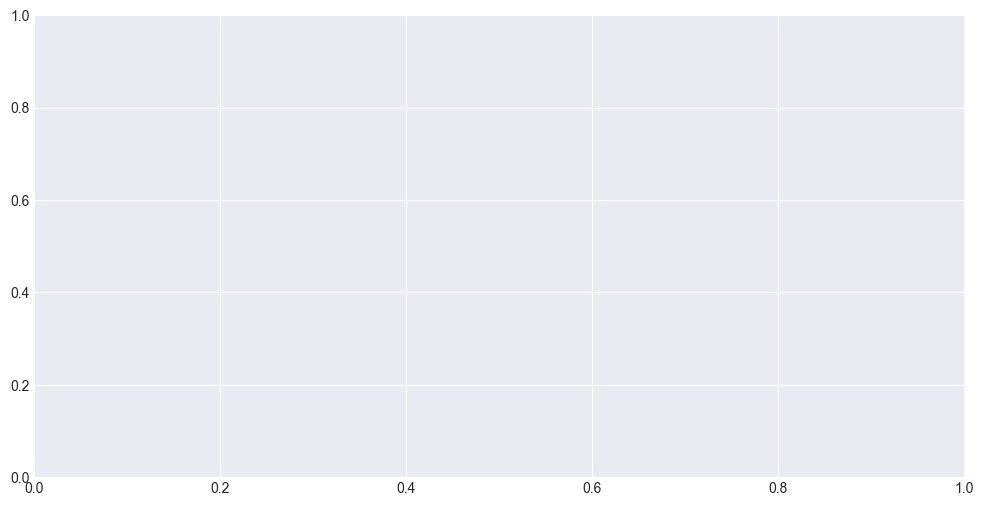

In [32]:
# Bar chart: Süpermarket karşılaştırması
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if sm == best_market else 'steelblue' for sm in results_1['supermarket']]
bars = ax.bar(results_1['supermarket'], results_1['total_price'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Değerleri bar üzerine yaz
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'£{height:.2f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xlabel('Süpermarket', fontweight='bold', fontsize=12)
ax.set_ylabel('Toplam Fiyat (£)', fontweight='bold', fontsize=12)
ax.set_title('Sepet Optimizasyonu: Süpermarket Fiyat Karşılaştırması', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# En ucuz marketi vurgula
ax.axhline(y=best_price, color='green', linestyle='--', linewidth=2, alpha=0.5, label=f'En Ucuz: {best_market}')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/figures/32_basket_optimization_example1.png', dpi=300, bbox_inches='tight')
print('💾 Grafik kaydedildi: 32_basket_optimization_example1.png')
plt.show()

### 2.3 Ürün Bazında Detaylı Karşılaştırma

📊 ÜRÜN BAZINDA FİYAT KARŞILAŞTIRMASI
Empty DataFrame
Columns: [ASDA, Aldi, Morrisons, Sains, Tesco]
Index: []


ValueError: zero-size array to reduction operation fmin which has no identity

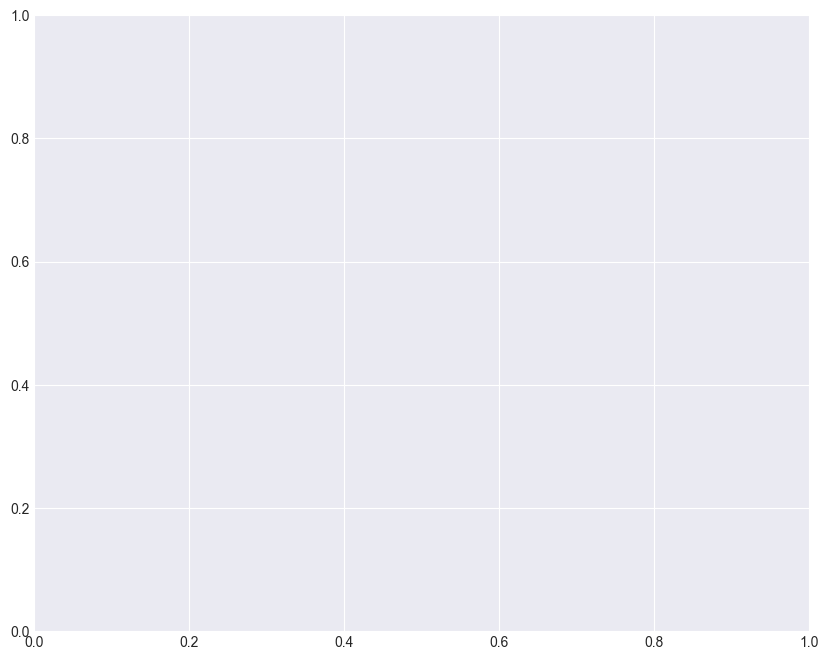

In [33]:
# Seçilen ürünler için her süpermarketteki fiyatları göster
selected_products_df = price_matrix.loc[price_matrix.index.isin(example_basket_1)]

print('📊 ÜRÜN BAZINDA FİYAT KARŞILAŞTIRMASI')
print('='*120)
print(selected_products_df.to_string())

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(selected_products_df, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            linewidths=1, linecolor='black', cbar_kws={'label': 'Fiyat (£)'},
            ax=ax, mask=selected_products_df.isna())

ax.set_xlabel('Süpermarket', fontweight='bold', fontsize=12)
ax.set_ylabel('Ürün', fontweight='bold', fontsize=12)
ax.set_title('Ürün Bazında Fiyat Karşılaştırması (Heatmap)', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('../outputs/figures/33_product_price_heatmap.png', dpi=300, bbox_inches='tight')
print('\n💾 Grafik kaydedildi: 33_product_price_heatmap.png')
plt.show()

---
## 🎲 PART 3: Rastgele Sepet Analizi (Monte Carlo Simülasyonu)

### 3.1 Birden Fazla Rastgele Sepet Testi

In [34]:
# 100 rastgele sepet oluştur ve en ucuz marketi bul
print('🎲 MONTE CARLO SİMÜLASYONU: 100 Rastgele Sepet Analizi')
print('='*70)

np.random.seed(42)
n_simulations = 100
basket_size = 10  # Her sepette 10 ürün

simulation_results = []

for i in range(n_simulations):
    # Rastgele ürünler seç
    random_products = np.random.choice(common_products, size=basket_size, replace=False).tolist()
    
    # Optimizasyon yap
    results, _ = optimize_basket(random_products, price_matrix)
    
    if len(results) > 0:
        best_market = results.iloc[0]['supermarket']
        best_price = results.iloc[0]['total_price']
        
        simulation_results.append({
            'basket_id': i + 1,
            'best_market': best_market,
            'total_price': best_price
        })

sim_df = pd.DataFrame(simulation_results)

print(f'\n✅ {n_simulations} sepet analiz edildi')
print(f'\n📊 EN UCUZ MARKET İSTATİSTİKLERİ:')
market_wins = sim_df['best_market'].value_counts()
print(market_wins)

print(f'\n💰 ORTALAMA SEPET FİYATLARI (Market Bazında):')
avg_prices = sim_df.groupby('best_market')['total_price'].mean().sort_values()
for market, price in avg_prices.items():
    print(f'   {market}: £{price:.2f}')

🎲 MONTE CARLO SİMÜLASYONU: 100 Rastgele Sepet Analizi

✅ 100 sepet analiz edildi

📊 EN UCUZ MARKET İSTATİSTİKLERİ:
best_market
Morrisons    93
Tesco         7
Name: count, dtype: int64

💰 ORTALAMA SEPET FİYATLARI (Market Bazında):
   Morrisons: £14.61
   Tesco: £29.72


### 3.2 Simülasyon Sonuçları Görselleştirme

💾 Grafik kaydedildi: 34_monte_carlo_simulation.png


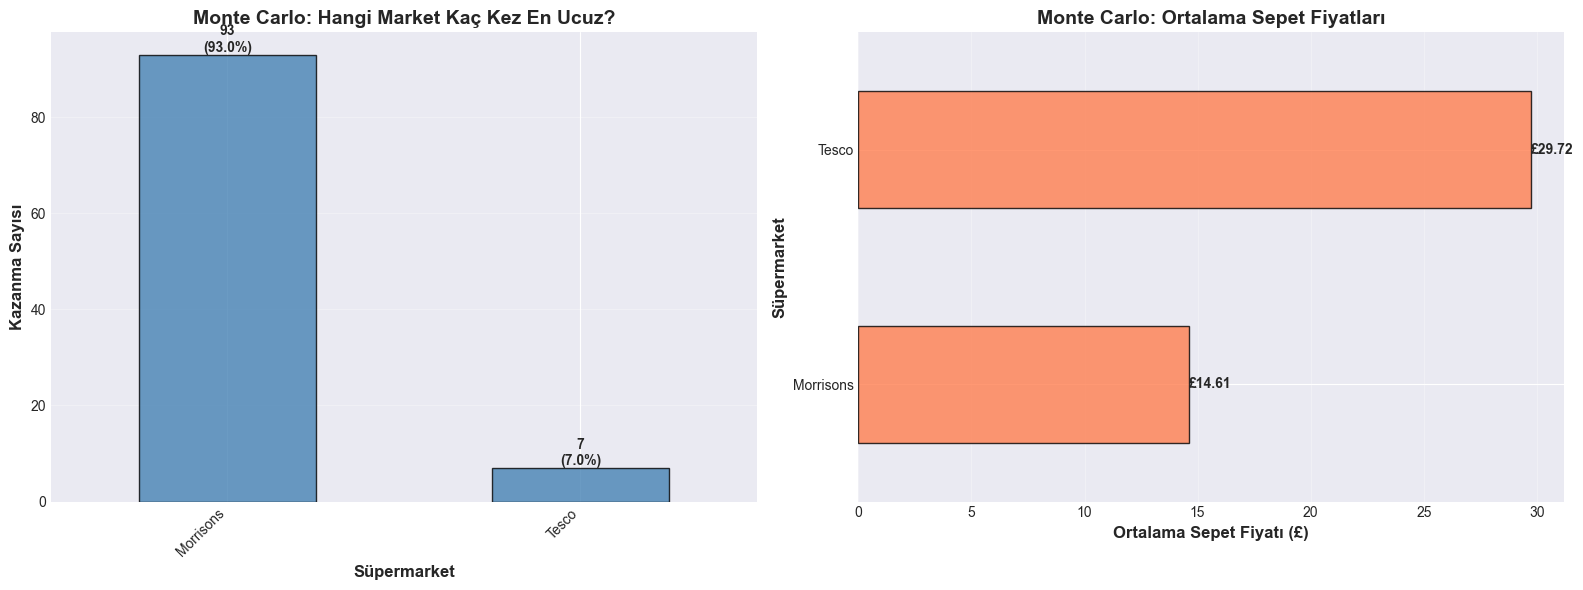

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sol: En ucuz market dağılımı
market_wins.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Süpermarket', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Kazanma Sayısı', fontweight='bold', fontsize=12)
axes[0].set_title('Monte Carlo: Hangi Market Kaç Kez En Ucuz?', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

for i, v in enumerate(market_wins.values):
    axes[0].text(i, v, f'{v}\n({v/n_simulations*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Sağ: Ortalama sepet fiyatları
avg_prices.plot(kind='barh', ax=axes[1], color='coral', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Ortalama Sepet Fiyatı (£)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Süpermarket', fontweight='bold', fontsize=12)
axes[1].set_title('Monte Carlo: Ortalama Sepet Fiyatları', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='x')

for i, v in enumerate(avg_prices.values):
    axes[1].text(v, i, f'£{v:.2f}', ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/figures/34_monte_carlo_simulation.png', dpi=300, bbox_inches='tight')
print('💾 Grafik kaydedildi: 34_monte_carlo_simulation.png')
plt.show()

---
## 💡 PART 4: İnteraktif Sepet Optimizasyon Fonksiyonu

In [36]:
def interactive_basket_optimizer(product_list, price_matrix, show_plot=True):
    """
    Kullanıcı dostu sepet optimizasyon fonksiyonu
    
    Args:
        product_list: Ürün isimleri listesi
        price_matrix: Fiyat matrisi
        show_plot: Grafik göster (True/False)
    """
    print('\n' + '='*80)
    print('🛒 SEPET OPTİMİZASYONU BAŞLATILDI'.center(80))
    print('='*80)
    
    # Seçilen ürünleri listele
    print(f'\n📋 Sepetinizdeki Ürünler ({len(product_list)} adet):')
    for i, prod in enumerate(product_list, 1):
        print(f'   {i}. {prod}')
    
    # Optimizasyon yap
    results, details = optimize_basket(product_list, price_matrix)
    
    if len(results) == 0:
        print('\n❌ Bu ürünler için fiyat bilgisi bulunamadı!')
        return None
    
    # Sonuçları göster
    print(f'\n\n📊 SÜPERMARKET KARŞILAŞTIRMASI:')
    print('-'*80)
    print(f'{'Süpermarket':<20} {'Toplam':<12} {'Mevcut Ürün':<15} {'Eksik Ürün':<15}')
    print('-'*80)
    
    for _, row in results.iterrows():
        print(f'{row["supermarket"]:<20} £{row["total_price"]:>9.2f}  {row["available_products"]:>12}    {row["missing_products"]:>12}')
    
    # En iyi öneriyi vurgula
    best_market = results.iloc[0]['supermarket']
    best_price = results.iloc[0]['total_price']
    best_available = results.iloc[0]['available_products']
    
    print('\n' + '='*80)
    print(f'🏆 ÖNERİ: {best_market}'.center(80))
    print(f'💰 Toplam Tutar: £{best_price:.2f}'.center(80))
    print(f'✅ Mevcut Ürün: {best_available}/{len(product_list)}'.center(80))
    
    # Tasarruf hesapla
    if len(results) > 1:
        worst_price = results.iloc[-1]['total_price']
        savings = worst_price - best_price
        print(f'💵 Tasarruf: £{savings:.2f} (En pahalıya göre %{(savings/worst_price)*100:.1f})'.center(80))
    
    print('='*80 + '\n')
    
    # Grafik göster
    if show_plot and len(results) > 1:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        colors = ['green' if sm == best_market else 'lightblue' for sm in results['supermarket']]
        bars = ax.bar(results['supermarket'], results['total_price'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'£{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        ax.set_xlabel('Süpermarket', fontweight='bold', fontsize=12)
        ax.set_ylabel('Toplam Fiyat (£)', fontweight='bold', fontsize=12)
        ax.set_title('Sepet Optimizasyonu: En Ucuz Market', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    return results, details

print('✅ İnteraktif optimizasyon fonksiyonu hazır')

SyntaxError: f-string: expecting '}' (1999200625.py, line 29)

### 4.1 Örnek Kullanım

In [37]:
# Örnek sepet 2: Haftalık alışveriş
weekly_shopping = [
    'Tesco Milk Whole 4 Pint/2.27L',
    'Tesco British Chicken Breast Fillets 300G',
    'Tesco Carrots 1Kg',
    'Tesco White Bread Thick 800G',
    'Tesco Bananas Loose',
    'Tesco Mature Cheddar 350G',
    'Tesco Pure Orange Juice 1 Litre',
    'Tesco Free Range Mixed Weight Eggs 6 Pack'
]

results, details = interactive_basket_optimizer(weekly_shopping, price_matrix)

NameError: name 'interactive_basket_optimizer' is not defined

---
## 💾 PART 5: Fonksiyonları Kaydetme

In [38]:
# Fiyat matrisini kaydet
price_matrix.to_csv('../data/processed/price_matrix.csv')
print('✅ Fiyat matrisi kaydedildi: price_matrix.csv')

# Fonksiyonları Python dosyası olarak kaydet
import joblib

basket_optimizer_functions = {
    'create_price_matrix': create_price_matrix,
    'optimize_basket': optimize_basket,
    'interactive_basket_optimizer': interactive_basket_optimizer
}

joblib.dump(basket_optimizer_functions, '../models/basket_optimizer.pkl')
print('✅ Sepet optimizasyon fonksiyonları kaydedildi: basket_optimizer.pkl')

✅ Fiyat matrisi kaydedildi: price_matrix.csv


NameError: name 'interactive_basket_optimizer' is not defined

---
## 📊 PART 6: Özet Rapor

In [39]:
print('='*80)
print('📊 SEPET OPTİMİZASYONU - ÖZET RAPOR')
print('='*80)

print('\n1️⃣ ANALİZ KAPSAMI:')
print(f'   • Toplam Ürün: {price_matrix.shape[0]:,}')
print(f'   • Süpermarket Sayısı: {price_matrix.shape[1]}')
print(f'   • Ortak Ürün: {len(common_products):,} (En az 3 markette)')

print('\n2️⃣ MONTE CARLO SİMÜLASYONU (100 Sepet):')
for market, count in market_wins.items():
    print(f'   • {market:20} {count:3} kez en ucuz ({count/n_simulations*100:5.1f}%)')

print('\n3️⃣ ORTALAMA SEPET FİYATLARI:')
for market, price in avg_prices.items():
    print(f'   • {market:20} £{price:6.2f}')

print('\n4️⃣ İŞ DEĞERİ:')
print('   ✅ Tüketiciler için tasarruf fırsatı')
print('   ✅ Marketler için rekabet analizi')
print('   ✅ Fiyat karşılaştırma platformları için altyapı')
print('   ✅ Akıllı alışveriş uygulamaları için temel')

print('\n5️⃣ KAYDEDILEN DOSYALAR:')
print('   ✅ price_matrix.csv')
print('   ✅ basket_optimizer.pkl')
print('   ✅ 3 görselleştirme (PNG)')

print('\n' + '='*80)
print('✅ SEPET OPTİMİZASYONU TAMAMLANDI!')
print('🎯 Sonraki Adım: Web/Mobil Arayüz Entegrasyonu')
print('='*80)

📊 SEPET OPTİMİZASYONU - ÖZET RAPOR

1️⃣ ANALİZ KAPSAMI:
   • Toplam Ürün: 1,579
   • Süpermarket Sayısı: 5
   • Ortak Ürün: 39 (En az 3 markette)

2️⃣ MONTE CARLO SİMÜLASYONU (100 Sepet):
   • Morrisons             93 kez en ucuz ( 93.0%)
   • Tesco                  7 kez en ucuz (  7.0%)

3️⃣ ORTALAMA SEPET FİYATLARI:
   • Morrisons            £ 14.61
   • Tesco                £ 29.72

4️⃣ İŞ DEĞERİ:
   ✅ Tüketiciler için tasarruf fırsatı
   ✅ Marketler için rekabet analizi
   ✅ Fiyat karşılaştırma platformları için altyapı
   ✅ Akıllı alışveriş uygulamaları için temel

5️⃣ KAYDEDILEN DOSYALAR:
   ✅ price_matrix.csv
   ✅ basket_optimizer.pkl
   ✅ 3 görselleştirme (PNG)

✅ SEPET OPTİMİZASYONU TAMAMLANDI!
🎯 Sonraki Adım: Web/Mobil Arayüz Entegrasyonu
